# RSNA Resnet 50 Model [Train]

In [1]:
! pip install -q git+https://github.com/keras-team/keras-cv

In [2]:
#Import required packages
import os
#KerasCore makes the notebook backend agnostic set backend to tensorflow
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import CosineDecay, PolynomialDecay
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from keras.metrics import BinaryAccuracy, CategoricalAccuracy, Recall
import keras_tuner as kt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Configuration

A particularly good practise is to have a configuration class for your notebooks. This not only keeps your configurations all at a single place but also becomes handy to map the configs to the performance of the model.

Please play around with the configurations and see how the performance of the model changes.

In [3]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 32
    EPOCHS = 25
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

# Reproducibility

We would want this notebook to have reproducible results. Here we set the seed for all the random algorithms so that we can reproduce the experiments each time exactly the same way.

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [5]:
MAIN_FOLDER = f'/kaggle/input/rsna-preprocessed'

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [6]:
#Load training data from a CSV file into a Pandas DataFrame
dataframe = pd.read_csv(f"{MAIN_FOLDER}/train.csv")

#Create a new column 'image_path' by concatenating folder and file information
dataframe["image_path"] = (
    f"{MAIN_FOLDER}/train_images"
    + "/" + dataframe.patient_id.astype(str)
    + "/" + dataframe.series_id.astype(str)
    + "/" + dataframe.instance_number.astype(str) + ".png"
)

#Remove duplicate rows from the DataFrame, if any
dataframe = dataframe.drop_duplicates()

#Display the first few rows of the DataFrame to inspect the data
dataframe.head()


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-preprocessed/train_images/1...,512,512


We partition the training dataset into two subsets: one for training and another for validation, following a standard practice in Machine Learning pipelines. Our goal is not only to train the model but also to validate its training.

An important consideration is maintaining an aligned data distribution between the training and validation data. To achieve this, we group the labels and then perform the dataset split. This approach guarantees a consistent data distribution across both the training and validation sets.

In [7]:
#Function to handle the split for each group
def split_group(group, test_size=0.2):
    """
    Splits a given group into training and validation sets.

    Parameters:
    - group: Pandas DataFrame
        The group to be split into training and validation sets.
    - test_size: float, optional (default=0.2)
        The proportion of the group to be allocated to the validation set when the group has more than one sample.

    Returns:
    - Tuple of Pandas DataFrames
        Returns a tuple containing the training and validation sets.
        For single-sample groups, one of the DataFrames will be empty.
    """
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

#Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

#Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [8]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

# Data Pipeline

In [9]:
def decode_image_and_label(image_path, label):
    """
    Decodes an image from the given file path and processes the label.

    Parameters:
    - image_path: str
        File path to the image.
    - label: tf.Tensor
        Tensor containing label information.

    Returns:
    - Tuple of tf.Tensor
        Returns a tuple containing the decoded image and processed label.
    """
    #Read the image file
    file_bytes = tf.io.read_file(image_path)
    #Decode the PNG image with 3 channels and convert to uint8
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    #Resize the image to the specified size using bilinear interpolation
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    #Convert image to float32 and normalize values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    #Cast the label to float32
    label = tf.cast(label, tf.float32)
    #Extract specific label components for individual organs
    #bowel, fluid, kidney, liver, spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)


def apply_augmentation(images, labels):
    """
    Applies data augmentation to a batch of images and their corresponding labels.

    Parameters:
    - images: tf.Tensor
        Tensor containing a batch of images.
    - labels: Tuple of tf.Tensor
        Tuple containing label information for different organs.

    Returns:
    - Tuple of tf.Tensor
        Returns a tuple containing the augmented images and unchanged labels.
    """
    #Define an augmenter with various image transformations
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
            keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomContrast(factor=0.1),
        ]
    )
    #Apply augmentation to the images
    augmented_images = augmenter(images)
    
    return (augmented_images, labels)


def build_dataset(image_paths, labels):
    """
    Builds a TensorFlow dataset from image paths and labels, including decoding and augmentation.

    Parameters:
    - image_paths: List of str
        List containing file paths to the images.
    - labels: tf.Tensor
        Tensor containing label information.

    Returns:
    - tf.data.Dataset
        Returns a TensorFlow dataset ready for model training.
    """
    #Create a dataset from image paths and labels
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)
        .prefetch(config.AUTOTUNE)
    )
    
    return ds


In [10]:
#Set paths and labels
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

#Build dataset
ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([32, 256, 256, 3]),
 [TensorShape([32, 1]),
  TensorShape([32, 1]),
  TensorShape([32, 3]),
  TensorShape([32, 3]),
  TensorShape([32, 3])])

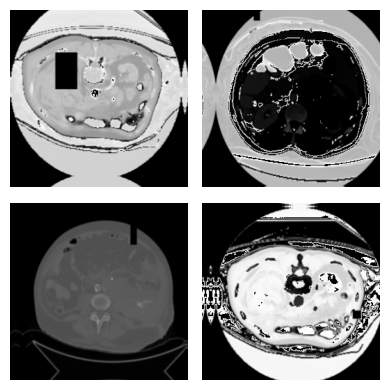

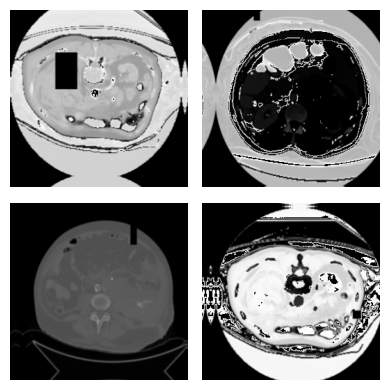

In [11]:
#Display images
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=2,
    cols=2,
)

# Build Model

We are going to load a pretrained model from the [list of avaiable backbones in KerasCV](https://keras.io/api/keras_cv/models/backbones/). We are using the `ResNetBackbone` as our backbone. The practise of using a pretrained model and finetuning it to a specific dataset is prevalent in the DL community.

We use the [Functional API](https://keras.io/guides/functional_api/) of Keras to build the model. The design of the model would be such that we input a single image and we get different heads for the various predictions we need (kidney, spleen...).

We have also added a Learning Rate scheduler for you to work with. When an athlete trains, the first step is always to warm up. We take a similar approach to training our models. We warm up with model where the learning rate increses from the initial LR to a higher LR. After the warmup stage we provide a decay algorithm (cosine here). A list of all the learning rate scheduler can be found [here](https://keras.io/api/optimizers/learning_rate_schedules/).

In [12]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=240800
warmup_steps=24080
decay_steps=216720


# Build Model

### ResNet-50

Short for Residual Network with 50 layers, is a deep learning architecture that belongs to a family of neural networks known as residual networks. It was introduced by Microsoft Research in 2015 and is particularly known for its effectiveness in training very deep neural networks. The key innovation in ResNet is the introduction of residual blocks, which enable the training of deeper networks by mitigating the vanishing gradient problem.

In a residual block, the input from the previous layer is combined with the output of the current layer, allowing the network to learn residual mappings. This facilitates the training of deeper networks while addressing the challenges associated with gradient degradation.

For a computer vision problem like identifying abdominal trauma in CT scans, ResNet-50 can be a valuable choice for several reasons:

1. **Depth and Capacity:** ResNet-50 is a relatively deep architecture with 50 layers, enabling it to capture intricate features and patterns in complex medical images. This depth is crucial for tasks where the discrimination between different types of abnormalities is subtle and requires a nuanced understanding.

2. **Feature Extraction:** The hierarchical structure of ResNet-50 allows it to automatically learn hierarchical features from the input data. In the context of abdominal trauma detection, this can be crucial for identifying relevant structures, abnormalities, or patterns indicative of trauma.

3. **Transfer Learning:** Pre-trained versions of ResNet-50 on large image datasets (e.g., ImageNet) are often available. Transfer learning with such pre-trained models allows the model to leverage knowledge gained from diverse datasets, enhancing its ability to generalize and perform well even with limited medical data.

4. **Residual Connections:** The residual connections help in mitigating the risk of vanishing gradients, making it easier to train deep networks. This is especially beneficial for medical imaging tasks where detailed and nuanced features might be distributed across multiple layers.

5. **Community Support:** ResNet-50 is a well-established and widely used architecture in the deep learning community. This means that there are ample resources, pre-trained models, and community support available, which can simplify the implementation and troubleshooting process.

In summary, ResNet-50 is a powerful deep learning architecture that can effectively address the challenges of identifying abdominal trauma in CT scans by leveraging its depth, feature extraction capabilities, and the benefits of residual connections. Its proven performance in various computer vision tasks, coupled with the potential for transfer learning, makes it a valuable tool for medical image analysis.

### Class Dependencies:

**Complementarity:**

The pairs, such as bowel_injury and bowel_healthy, or extravasation_injury and extravasation_healthy, exhibit perfect complementarity, where their cumulative probability is consistently equal to 1.0.

**Simplification:**

To enhance model efficiency, only {bowel/extravasation}_injury classes will be incorporated. The corresponding healthy status can be inferred through a sigmoid function, streamlining the architecture while preserving predictive accuracy.

**Softmax:**

For {kidney/liver/spleen}_{healthy/low/high} classifications, the application of softmax ensures that the collective probabilities sum to 1.0 for each organ. This not only simplifies the model but also maintains vital information integrity in the classification process.

In [13]:
hp = kt.HyperParameters()

In [14]:
def build_model(hp):
    """
    Builds a custom neural network model based on hyperparameter configurations.

    Parameters:
    - hp: keras_tuner.HyperParameters
        Hyperparameter object for tuning model configurations.

    Returns:
    - tf.keras.Model
        Returns the compiled TensorFlow model.
    """
    #Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)
    
    #Adjust hyperparameters
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    hp_activation = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'silu'])
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'adam', 'RMSprop'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.2)
    hp_reg_strength = hp.Choice('reg_strength', values=[1e-5, 1e-4, 1e-3])
    
    #Define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset('resnet50_imagenet')
    backbone.include_rescaling = False
    x = backbone(inputs)
    
    #GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    #Define 'necks' for each head
    x_bowel = Dense(32, activation=hp_activation, kernel_regularizer=l2(hp_reg_strength))(x)
    x_bowel = BatchNormalization()(x_bowel)
    x_bowel = Dropout(dropout_rate)(x_bowel)

    x_liver = Dense(32, activation=hp_activation, kernel_regularizer=l2(hp_reg_strength))(x)
    x_liver = BatchNormalization()(x_liver)
    x_liver = Dropout(dropout_rate)(x_liver)


    #Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_liver) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_liver) # use softmax for the spleen head
    
    #Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    #Create model
    print('[INFO] Building the model...')
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    #Cosine Decay with Warm-up
    initial_learning_rate = 1e-5
    warmup_steps = int(0.1 * decay_steps)

    learning_rate_schedule = CosineDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        alpha=0.0
    )

    def warmup_schedule(step):
        return initial_learning_rate + step / warmup_steps * (hp_learning_rate - initial_learning_rate)

    learning_rate_schedule = PolynomialDecay(
        initial_learning_rate,
        decay_steps=warmup_steps,
        end_learning_rate=hp_learning_rate,
        power=1.0,
        cycle=False
    )
    #Define the optimizer choices
    optimizer_choices = {
        'adam': Adam,
        'sgd': SGD,
        'RMSprop': RMSprop,
    }
    #Compile the model
    #Select the optimizer class based on the hyperparameter value
    selected_optimizer = optimizer_choices[hp_optimizer]

    #Instantiate the optimizer with the specified learning rate
    optimizer = selected_optimizer(learning_rate=learning_rate_schedule)
    loss = {
        "bowel": BinaryCrossentropy(),
        "extra": BinaryCrossentropy(),
        "liver": CategoricalCrossentropy(),
        "kidney": CategoricalCrossentropy(),
        "spleen": CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": [BinaryAccuracy(), Recall()],
        "extra": [BinaryAccuracy(), Recall()],
        "liver": [CategoricalAccuracy(), Recall()],
        "kidney": [CategoricalAccuracy(), Recall()],
        "spleen": [CategoricalAccuracy(), Recall()],
    }

    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

# Optimize Model Hyperparameters

## Bayesian Optimization:

**Efficient Exploration:**
Bayesian Optimization is a probabilistic model-based optimization technique that efficiently explores the hyperparameter space. It intelligently selects hyperparameters to evaluate based on the probabilistic model, allowing it to focus on promising regions.

**Adaptive Exploration-Exploitation Trade-off:**
The alpha and beta parameters in Bayesian Optimization control the balance between exploration and exploitation. A higher value of alpha encourages more exploration, while a higher value of beta emphasizes exploitation of promising regions. This adaptive trade-off helps in efficiently navigating the hyperparameter space.

**Automatic Hyperparameter Tuning:**
Bayesian Optimization automates the process of hyperparameter tuning, making it suitable for optimizing complex models with a large number of hyperparameters. It systematically explores the hyperparameter space, adapting its search based on the observed performance of previous configurations.

**Handles Noisy Objective Functions:**
Bayesian Optimization is robust in handling noisy or stochastic objective functions, which is common in machine learning tasks. It can deal with variations in performance due to factors like randomness in data or training.

**Sequential and Data-Efficient:**
Bayesian Optimization is a sequential approach where each new trial informs the next, making it data-efficient. It efficiently leverages information from previous trials to guide the search toward better-performing hyperparameter configurations.

In [15]:
#Define the custom objective
custom_objective = kt.Objective("val_loss", direction="min")

#Define the tuner
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=custom_objective,
    max_trials=10,
    num_initial_points=2,
    alpha=1e-2,
    beta=3,
)

#Start the search
tuner.search(
    train_ds,
    epochs=3,
    validation_data=val_ds,
)

Trial 10 Complete [00h 04m 50s]
val_loss: 3.375720500946045

Best val_loss So Far: 3.2796432971954346
Total elapsed time: 00h 49m 24s


In [16]:
#Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

#Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

[INFO] Building the model...
[INFO] Compiling the model...


In [17]:
#Define Early Stopping callback to prevent overfitting
earlystopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True
)

#Train the model with Early Stopping
print("[INFO] Training...")
history = best_model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
    callbacks=[earlystopping]
)


[INFO] Training...
Epoch 1/25
301/301 [==============================] - 101s 308ms/step - loss: 4.4465 - bowel_loss: 0.6867 - extra_loss: 0.6919 - liver_loss: 0.9921 - kidney_loss: 1.0317 - spleen_loss: 1.0429 - bowel_binary_accuracy: 0.5433 - bowel_recall_5: 0.6620 - extra_binary_accuracy: 0.5252 - extra_recall_6: 0.5691 - liver_categorical_accuracy: 0.6502 - liver_recall_7: 0.0468 - kidney_categorical_accuracy: 0.5145 - kidney_recall_8: 0.0589 - spleen_categorical_accuracy: 0.5499 - spleen_recall_9: 0.0186 - val_loss: 3.8740 - val_bowel_loss: 0.6932 - val_extra_loss: 0.6737 - val_liver_loss: 0.7289 - val_kidney_loss: 0.8669 - val_spleen_loss: 0.9102 - val_bowel_binary_accuracy: 0.4849 - val_bowel_recall_5: 0.0517 - val_extra_binary_accuracy: 0.6963 - val_extra_recall_6: 0.9988 - val_liver_categorical_accuracy: 0.8697 - val_liver_recall_7: 0.8697 - val_kidney_categorical_accuracy: 0.8113 - val_kidney_recall_8: 0.0000e+00 - val_spleen_categorical_accuracy: 0.6773 - val_spleen_recall_9

# Visualize the training plots

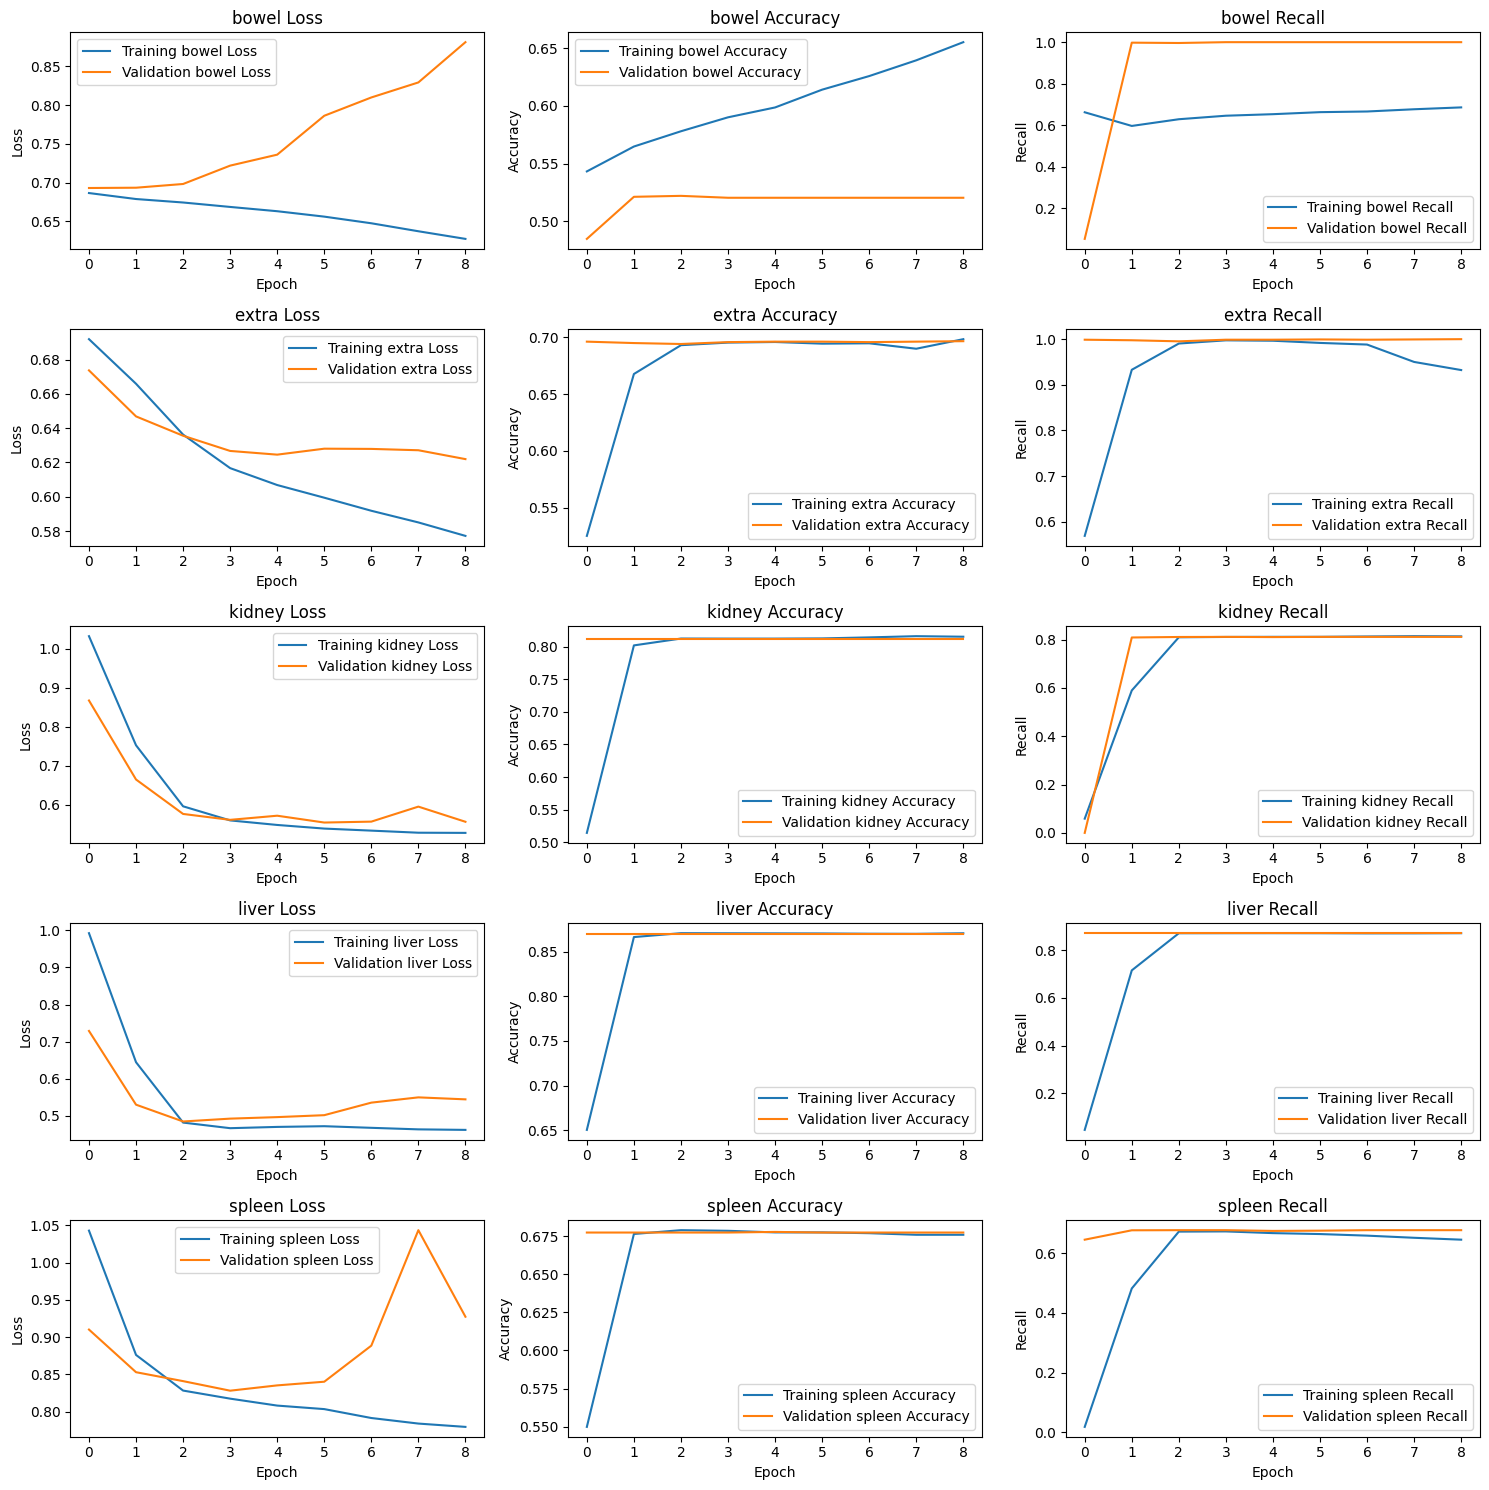

In [18]:
#Create a 5x3 grid for the subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

#Flatten axes to iterate through them
axes = axes.flatten()

#Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training loss
    axes[i*3].plot(history.history[name + '_loss'], label='Training ' + name + ' Loss')
    # Plot validation loss
    axes[i*3].plot(history.history['val_' + name + '_loss'], label='Validation ' + name + ' Loss')
    axes[i*3].set_title(name + ' Loss')
    axes[i*3].set_xlabel('Epoch')
    axes[i*3].set_ylabel('Loss')
    axes[i*3].legend()

    #Identify the correct name for accuracy metric
    acc_name = name + '_binary_accuracy' if name in ['bowel', 'extra'] else name + '_categorical_accuracy'

    #Plot training accuracy
    axes[i*3 + 1].plot(history.history[acc_name], label='Training ' + name + ' Accuracy')
    #Plot validation accuracy
    axes[i*3 + 1].plot(history.history['val_' + acc_name], label='Validation ' + name + ' Accuracy')
    axes[i*3 + 1].set_title(name + ' Accuracy')
    axes[i*3 + 1].set_xlabel('Epoch')
    axes[i*3 + 1].set_ylabel('Accuracy')
    axes[i*3 + 1].legend()

    #Find the recall metric with the highest epoch value
    recall_metric = [metric for metric in history.history.keys() if name + '_recall' in metric]
    max_recall_epoch = max(recall_metric, key=lambda x: int(x.split('_')[-1]))
    
    #Plot training recall for the latest epoch
    axes[i*3 + 2].plot(history.history[max_recall_epoch], label='Training ' + name + ' Recall')
    #Plot validation recall for the latest epoch
    axes[i*3 + 2].plot(history.history['val_' + max_recall_epoch], label='Validation ' + name + ' Recall')
    axes[i*3 + 2].set_title(name + ' Recall')
    axes[i*3 + 2].set_xlabel('Epoch')
    axes[i*3 + 2].set_ylabel('Recall')
    axes[i*3 + 2].legend()

plt.tight_layout()
plt.show()


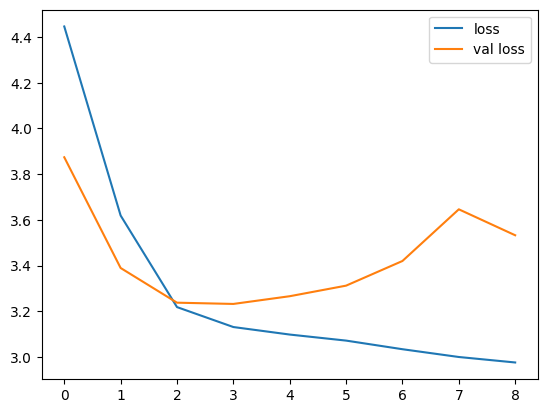

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [20]:
#Store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_binary_accuracy'][best_epoch]
best_recall_bowel = history.history['val_bowel_recall_5'][best_epoch]

best_acc_extra = history.history['val_extra_binary_accuracy'][best_epoch]
best_recall_extra = history.history['val_extra_recall_6'][best_epoch]

best_acc_liver = history.history['val_liver_categorical_accuracy'][best_epoch]
best_recall_liver = history.history['val_liver_recall_7'][best_epoch]

best_acc_kidney = history.history['val_kidney_categorical_accuracy'][best_epoch]
best_recall_kidney = history.history['val_kidney_recall_8'][best_epoch]

best_acc_spleen = history.history['val_spleen_categorical_accuracy'][best_epoch]
best_recall_spleen = history.history['val_spleen_recall_9'][best_epoch]

#Find mean accuracy and mean recall
best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])
best_recall = np.mean([best_recall_bowel, best_recall_extra, best_recall_liver, best_recall_kidney, best_recall_spleen])

print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Recall : {best_recall:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : Acc={best_acc_bowel:.3f}, Recall={best_recall_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : Acc={best_acc_extra:.3f}, Recall={best_recall_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : Acc={best_acc_liver:.3f}, Recall={best_recall_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : Acc={best_acc_kidney:.3f}, Recall={best_recall_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : Acc={best_acc_spleen:.3f}, Recall={best_recall_spleen:.3f}')


>>>> BEST Loss  : 3.232
>>>> BEST Acc   : 0.715
>>>> BEST Recall : 0.871
>>>> BEST Epoch : 3

ORGAN Acc:
  >>>> Bowel           : Acc=0.520, Recall=1.000
  >>>> Extravasation   : Acc=0.696, Recall=0.999
  >>>> Liver           : Acc=0.870, Recall=0.870
  >>>> Kidney          : Acc=0.811, Recall=0.811
  >>>> Spleen          : Acc=0.677, Recall=0.677


In [21]:
#Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

#Print or use the best hyperparameters
print("Best Hyperparameters:")
print(best_hps)

Best Hyperparameters:
{'learning_rate': 0.1, 'activation': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.1, 'reg_strength': 1e-05}


## Store the model for inference

In [22]:
# Save the model
best_model.save_weights("rsna-atd-resnet50_weights.h5")

# Next Steps

1. Please refer to the [Inference Notebook](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer) to learn about submitting to the competition
2. Dive deep into [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

# Credits

This notebook was forked from https://www.kaggle.com/code/awsaf49/rsna-atd-cnn-tpu-train